# Image Caption Generator

## Note

You have to upload the flick8k dataset in your google drive and mount it here in colab & the dataset should be in .zip format. After this the code will take care of the rest if you provide the zip file location properly

## Details
Date: 20 Dec, 2023

Platform: Colab

Dataset: Flickr8k

Python: 3.10.12

## Imports

In [1]:
# Imports
import numpy as np
import pandas as pd
import os

## Mounting the Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzipping the dataset

In [3]:
!unzip /content/drive/MyDrive/data/flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

## Tokenization & Prediction

In [5]:
import torch
import numpy as np
import torch.nn as nn
from transformers import GPT2Tokenizer
# Create a blank Byte-Pair Encoding tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

encoded = tokenizer.encode("A sample caption")
print(encoded)
decoded = tokenizer.decode(encoded)
print(decoded)


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

[32, 6291, 8305]
A sample caption


We now create a dataset class with PyTorch to process the images and captions.

In [6]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchvision.io import read_image
from PIL import Image
import random
from transformers import PreTrainedTokenizerFast


# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit most pre-trained models
    transforms.ToTensor(),
])

class Flickr8kDataset(Dataset):
    def __init__(self, annotations_file, img_dir, tokenizer, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_captions = pd.read_csv(annotations_file)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.img_captions)//5

    def __getitem__(self, idx):
        file_name = self.img_captions.iloc[5*idx, 0]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path)
        caption = random.choice(self.img_captions.iloc[5*idx : 5*(idx+1), 1].tolist())
        tokenized_caption = self.tokenizer.encode(caption)
        if self.transform:
            image = self.transform(image)
        return image, tokenized_caption

img_dir = '/content/Images'
annotations_file = '/content/captions.txt'

dataset = Flickr8kDataset(annotations_file=annotations_file, img_dir=img_dir, tokenizer=tokenizer, transform=transform)


split_point = int(0.9*len(dataset))

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [split_point, len(dataset) - split_point])


In [7]:
from torch.utils.data import DataLoader, random_split

def collate_fn(data):
    images, captions = zip(*data)
    images = torch.stack(images, 0)

    captions = [[tokenizer.bos_token_id] + cap + [tokenizer.eos_token_id] for cap in captions]

    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths), dtype=torch.long)
    # Create attention masks
    masks = torch.zeros(len(captions), max(lengths), dtype=torch.long)

    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = torch.LongTensor(cap)
        masks[i, :end] = 1

    return images, targets, masks

train_dataloader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn, shuffle=False)


Images batch shape: torch.Size([32, 3, 224, 224])
Captions batch size: 32
tensor(12)
tensor(0)


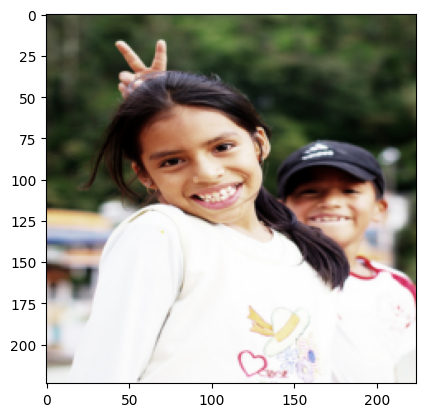

Label: !


In [8]:
images, captions, attention_masks = next(iter(train_dataloader))

def tensor_to_image(tensor):
    # Convert the tensor to a PIL Image
    return transforms.ToPILImage()(tensor)

print(f"Images batch shape: {images.size()}")
print(f"Captions batch size: {len(captions)}")

# Make sure the index is within bounds
index = torch.where(captions[0] == 0)[0][0] % len(captions[0])
print(index)

caption = captions[0][index]
print(caption)

label = tokenizer.decode(caption, skip_special_token=True)
img = tensor_to_image(images[0])
plt.imshow(img)
plt.show()
print(f"Label: {label}")



In [9]:
from transformers import GPT2LMHeadModel
from torchvision.models import resnet50

resnet = resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-2]) # Remove avg pool and fc layer

gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

resnet.to(device)
gpt2.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s]


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [10]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, resnet, gpt2):
        super(ImageCaptioningModel, self).__init__()
        self.resnet = resnet
        self.gpt2 = gpt2

        self.proj = nn.Linear(2048, gpt2.config.hidden_size)

    def forward(self, images, input_ids, attention_mask=None):
        img_features = self.resnet(images)
        img_features = img_features.mean([2,3])
        img_features = self.proj(img_features)

        input_embeddings = self.gpt2.transformer.wte(input_ids)
        combined_embeddings =  input_embeddings + img_features.unsqueeze(1)

        outputs = self.gpt2(inputs_embeds=combined_embeddings, attention_mask=attention_mask, labels=input_ids)
        return outputs

In [11]:
from transformers import AdamW

model = ImageCaptioningModel(resnet, gpt2)
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 10
print_every = 50


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    iteration_loss = 0

    for idx, batch in enumerate(train_dataloader, 1):
        batch = tuple(t.to(device) for t in batch)
        images, input_ids, masks = batch

        optimizer.zero_grad()

        outputs = model(images, input_ids, attention_mask = masks)
        loss = outputs.loss

        loss.backward()

        optimizer.step()

        total_loss +=loss.item()
        iteration_loss += loss.item()

        if idx % print_every == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} | Iteration {idx}/{len(train_dataloader)} | "
                  f"Training Loss: {iteration_loss / print_every:.3f}")
            iteration_loss = 0

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            images, input_ids, masks = batch
            outputs = model (images, input_ids, attention_mask=masks)
            loss = outputs.loss
            val_loss += loss.item()
    val_loss = val_loss / len(val_dataloader)

    print(f"Epoch {epoch + 1}/{num_epochs} | Training Loss: {total_loss / len(train_dataloader):.3f} | "
          f"Validation Loss: {val_loss:.3f}\n")





Epoch 1/10 | Iteration 50/228 | Training Loss: 4.191
Epoch 1/10 | Iteration 100/228 | Training Loss: 2.454
Epoch 1/10 | Iteration 150/228 | Training Loss: 1.802
Epoch 1/10 | Iteration 200/228 | Training Loss: 1.745
Epoch 1/10 | Training Loss: 2.438 | Validation Loss: 1.588

Epoch 2/10 | Iteration 50/228 | Training Loss: 1.673
Epoch 2/10 | Iteration 100/228 | Training Loss: 1.639
Epoch 2/10 | Iteration 150/228 | Training Loss: 1.655
Epoch 2/10 | Iteration 200/228 | Training Loss: 1.572
Epoch 2/10 | Training Loss: 1.631 | Validation Loss: 1.605

Epoch 3/10 | Iteration 50/228 | Training Loss: 1.523
Epoch 3/10 | Iteration 100/228 | Training Loss: 1.569
Epoch 3/10 | Iteration 150/228 | Training Loss: 1.529
Epoch 3/10 | Iteration 200/228 | Training Loss: 1.532
Epoch 3/10 | Training Loss: 1.540 | Validation Loss: 1.521

Epoch 4/10 | Iteration 50/228 | Training Loss: 1.433
Epoch 4/10 | Iteration 100/228 | Training Loss: 1.505
Epoch 4/10 | Iteration 150/228 | Training Loss: 1.454
Epoch 4/10 | I

In [13]:
def generate_caption(image, model, tokenizer, max_length=50, temperature=1.0):

    caption = [tokenizer.bos_token_id]

    model.eval()

    with torch.no_grad():
        for i in range(max_length):
            input_ids = torch.LongTensor(caption).unsqueeze(0)
            input_ids = input_ids.to(device)
            outputs = model(image.unsqueeze(0), input_ids)

            logits = outputs.logits[:, -1, :] / temperature
            predicted_id = logits.argmax(1).item()
            caption.append(predicted_id)

            if predicted_id == tokenizer.eos_token_id and i>1:
                break
    generated_caption = tokenizer.decode(caption, skip_special_tokens=True)
    return generated_caption

In [ ]:
tokenizer.eos_token_id

50256

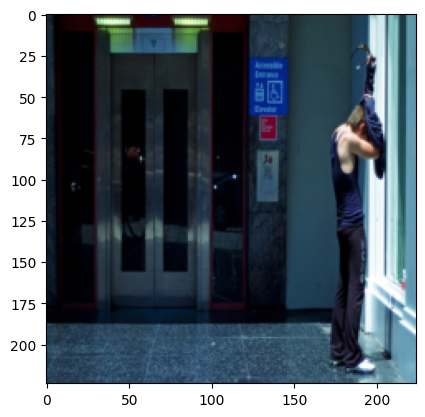

Label : A man in a black shirt is standing in front of a building with a sign.


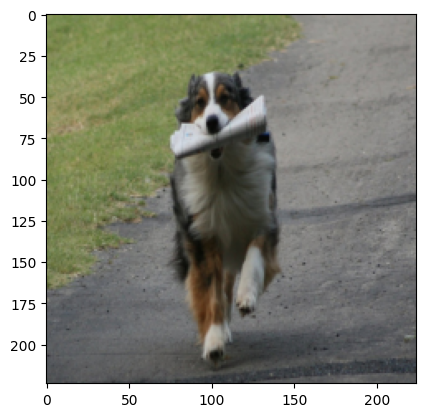

Label : A dog is running through a field of yellow and white flowers.


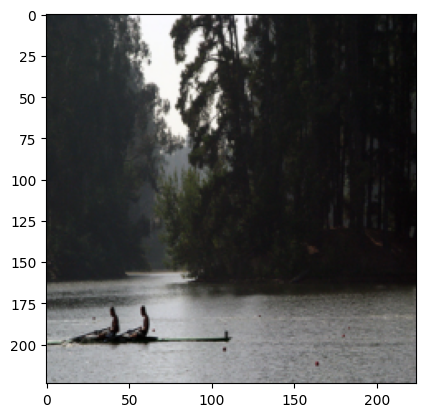

Label : A man is kayaking in a river with a large tree in the background.


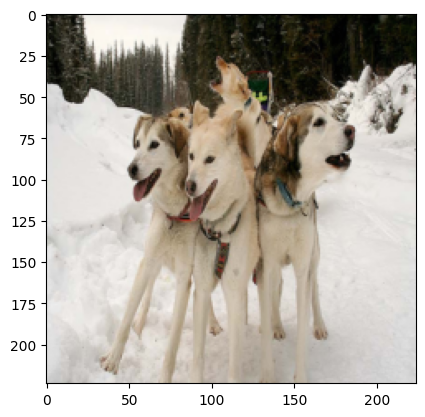

Label : A dog and a dog are playing in the snow.


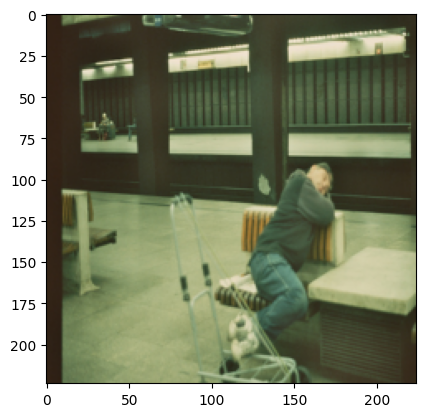

Label : A woman sits on a bench and reads a book.


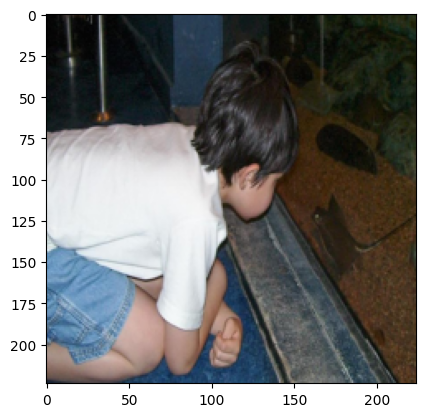

Label : A boy in a blue shirt is sitting on a bench and looking at a book.


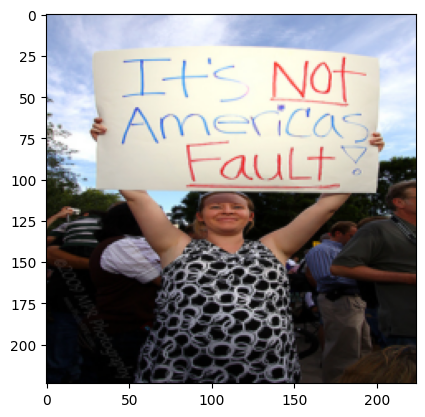

Label : A man in a white shirt and black pants is standing in front of a crowd of people.


In [17]:
images, _, _ = next(iter(val_dataloader))
for image in images[range(7)]:
    image = image.to(device)
    img = tensor_to_image(image)
    caption = generate_caption(image, model, tokenizer)

    plt.imshow(img)
    plt.show()
    print(f"Label : {caption}")

In [15]:
# Single Image

# images, _, _ = next(iter(val_dataloader))

# image = 'image-name.jpg'
# image = image.to(device)
# img = tensor_to_image(image)
# caption = generate_caption(image, model, tokenizer)

# plt.imshow(img)
# plt.show()
# print(f"Label : {caption}")